# Rejecting High Efficiency Muons 

In this notebook, I want to reject the high efficiency Muons and re-plot the ROC curve for e vs gamma for the 3-class case. 

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.manifold import TSNE

In [3]:
sys.path.append("..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.plot_utils import plot_classifier_response, plot_reduced_classifier_response, plot_2D_classifier_response

In [4]:
label_dict         = {"$\gamma$":0, "$e$":1, "$\mu$":2, '$\pi^0$':3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:'$\pi^0$'}

muon_softmax_index_dict = {"non-mu":0, "mu":1}

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

##  Load 2-class models and the associated data

In [5]:
locs_2_class = ['/data/WatChMaL/data/WatChMaL_short_tank_results/2_classes/full_indices/OD_veto_w_testing/2_Class_OD_veto_full/outputs']

titles_2_class = ['2 Class Extra Indices']

linecolor_2_class = [c[0] for _ in locs_2_class]
linestyle_2_class = ['-' for _ in locs_2_class]

raw_output_softmax_2_class = [np.load(loc + "/softmax.npy") for loc in locs_2_class]
raw_actual_labels_2_class  = [np.load(loc + "/labels.npy") for loc in locs_2_class]
raw_actual_indices_2_class = [np.load(loc + "/indices.npy") for loc in locs_2_class]

## Load 3-class model and the associated data

In [6]:
locs_3_class = ['/home/hlahiouel/WatChMaL/outputs/2021-02-11/08-36-41/outputs']

titles_3_class = ['3 Class Run 1']

linecolor_3_class = [c[1] for _ in locs_3_class]
linestyle_3_class = ['-' for _ in locs_3_class]

raw_output_softmax_3_class = [np.load(loc + "/softmax.npy") for loc in locs_3_class]
raw_actual_labels_3_class  = [np.load(loc + "/labels.npy") for loc in locs_3_class]
raw_actual_indices_3_class = [np.load(loc + "/indices.npy") for loc in locs_3_class]

## Load 4-class model and the associated data

In [7]:
locs_4_class = ['/home/hlahiouel/WatChMaL/outputs/2021-03-01/12-52-40/outputs',
                '/home/hlahiouel/WatChMaL/outputs/2021-03-01/13-08-00/outputs']

titles_4_class = ['4 Class Run 1 - Barrel Fix ',
                  '4 Class Run 2 - Barrel Fix']

linecolor_4_class = [c[2] for _ in locs_4_class]
linestyle_4_class = ['-' for _ in locs_4_class]

raw_output_softmax_4_class = [np.load(loc + "/softmax.npy") for loc in locs_4_class]
raw_actual_labels_4_class  = [np.load(loc + "/labels.npy") for loc in locs_4_class]
raw_actual_indices_4_class = [np.load(loc + "/indices.npy") for loc in locs_4_class]

In [8]:
titles = titles_3_class

linecolor = linecolor_3_class
linestyle = linestyle_3_class

softmaxes = raw_output_softmax_3_class
labels    = raw_actual_labels_3_class

In [9]:
for q in range(len(softmaxes)):
    softmax = softmaxes[q]
    print(softmax.shape)

(2756096, 3)


## Remove the High Efficiency Muons  

In [10]:
collapsed_class_scores_list, collapsed_class_labels_list = multi_collapse_test_output(raw_output_softmax_4_class, raw_actual_labels_4_class, label_dict, ignore_type='$e$',ignore_type2='$\pi^0$')

collapsed_class_labels_list = [collapsed_class_labels - 1 for collapsed_class_labels in collapsed_class_labels_list]
collapsed_class_scores_list = [collapsed_class_scores[:, 1:] for collapsed_class_scores in collapsed_class_scores_list]

############# compute short tank multi e/gamma ROC #############
fprs, tprs, thrs = multi_compute_roc(collapsed_class_scores_list, collapsed_class_labels_list, 
                                                         true_label=muon_softmax_index_dict["non-mu"], 
                                                         false_label=muon_softmax_index_dict["mu"],
                                                         normalize=True)


In [11]:
four_class_tpr = tprs[0]

In [12]:
four_class_thr = thrs[0]

In [16]:
efficiency = 0.98
tolerance = 0.000001

for i in range(len(four_class_tpr)):
    if (four_class_tpr[i] >= efficiency) and (four_class_tpr[i] <= efficiency+tolerance):
        print(four_class_tpr[i],i)

0.980000549045371 17029
0.980000549045371 17030


In [17]:
threshold_index = 17029

In [18]:
threshold = four_class_thr[threshold_index]

In [19]:
print(threshold)

0.9071751534938812


In [20]:
three_class_softmax = softmaxes[0]

In [21]:
three_class_labels = labels[0]

In [22]:
four_class_softmax = raw_output_softmax_4_class[0]

In [23]:
four_class_labels = raw_actual_labels_4_class[0]

In [24]:
idxs = []

for j in range(len(four_class_softmax)):
    if (four_class_softmax[j,0]+four_class_softmax[j,1]) <= threshold:
        idxs.append(j)
        
idxs = np.array(idxs)

In [25]:
event_list = []

for w in idxs:
    event_list.append(four_class_labels[w])
    
event_list = np.array(event_list)

In [26]:
gamma_events = []

e_events = []

muon_events = []

pion_events = []

for r in event_list:
    if r == 0:
        gamma_events.append(r)
    if r == 1:
        e_events.append(r)
    if r == 2:
        muon_events.append(r)
    if r == 3:
        pion_events.append(r)
        
print(len(gamma_events))
print(len(e_events))
print(len(muon_events))
print(len(pion_events))

453085
394183
648784
940496


In [27]:
new_softmax = np.delete(four_class_softmax,idxs,axis=0)
new_labels = np.delete(four_class_labels,idxs)

In [28]:
two_class_softmax = raw_output_softmax_2_class[0]

In [29]:
two_class_labels = raw_actual_labels_2_class[0]

In [30]:
new_softmax_2_class = np.delete(two_class_softmax,idxs,axis=0)
new_labels_2_class = np.delete(two_class_labels,idxs)

In [31]:
print(new_softmax.shape)
print(new_labels.shape)

(1285180, 4)
(1285180,)


In [32]:
print(new_softmax_2_class.shape)
print(new_labels_2_class.shape)

(2825788, 2)
(2825788,)


In [33]:
print(len(softmaxes))

1


In [34]:
softmaxes = softmaxes + [new_softmax, two_class_softmax, new_softmax_2_class]
labels = labels + [new_labels, two_class_labels, new_labels_2_class]
titles = titles + ["4-Class - Rejected Muons with 98% efficiency threshold", "2-Class - Extra Indices", "2-Class - Extra Indices - Rejected Muons with 98% efficiency threshold"]
linecolor = linecolor + [c[3],c[2],c[4]]
linestyle = linestyle + ['-','-','-']

In [35]:
print(len(softmaxes))

4


In [36]:
fprs, tprs, thrs = multi_compute_roc(softmaxes, labels, 
                                                     true_label=label_dict["$e$"], 
                                                     false_label=label_dict["$\gamma$"],
                                                     normalize=True)

## Plot ROC e vs gamma with Normalization 

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])


[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])


[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


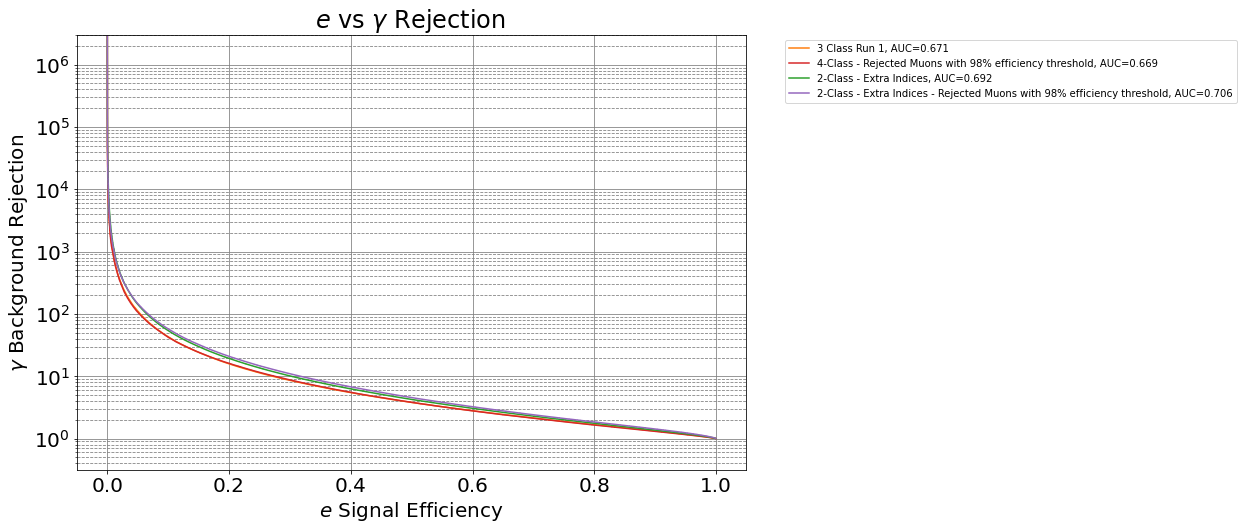

In [37]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[0,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


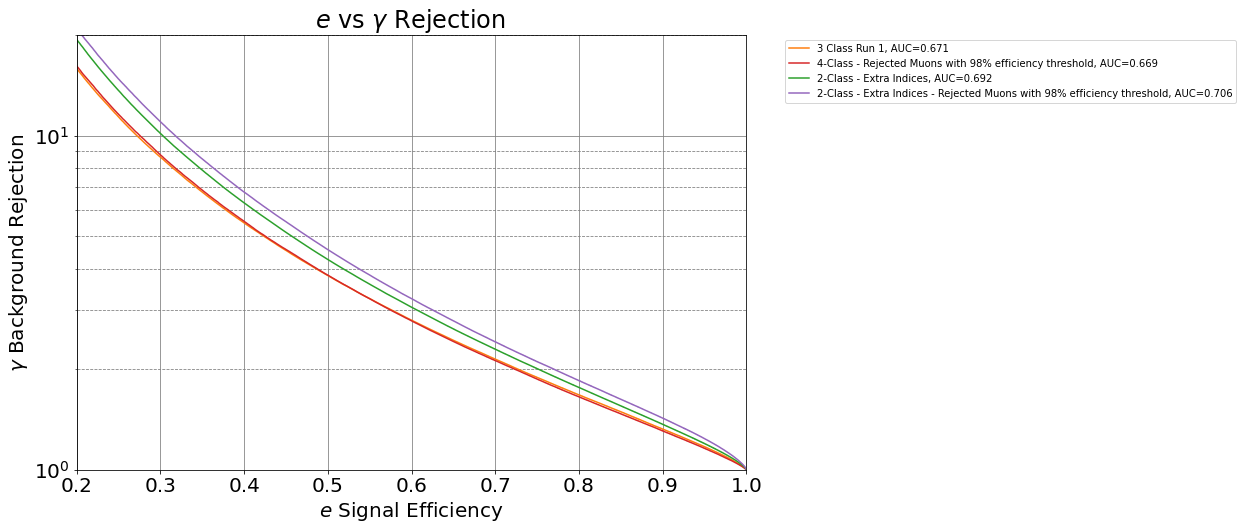

In [38]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\gamma$", 
                      fig_list=[1], 
                      xlims=[[0.2,1.0]],ylims=[[1e0,2e1]],
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)

## Likelihood Plots 

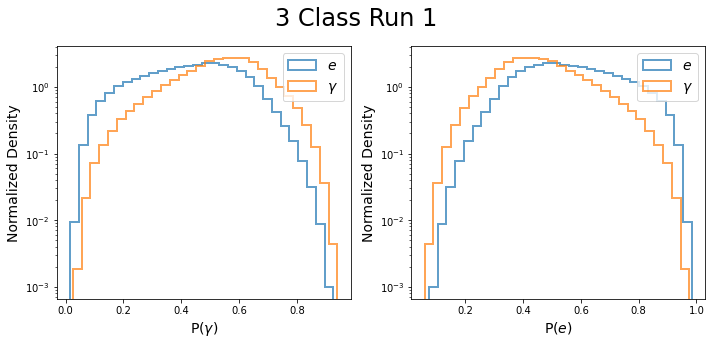

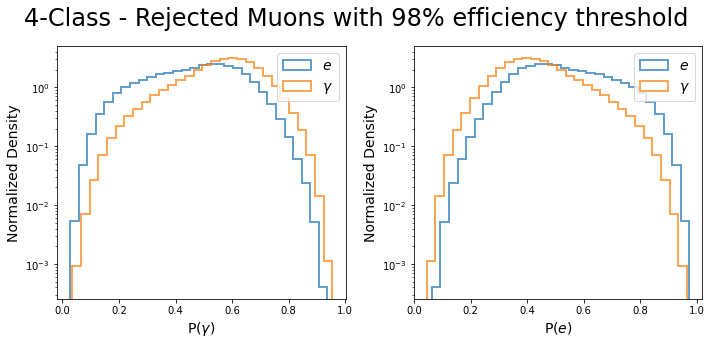

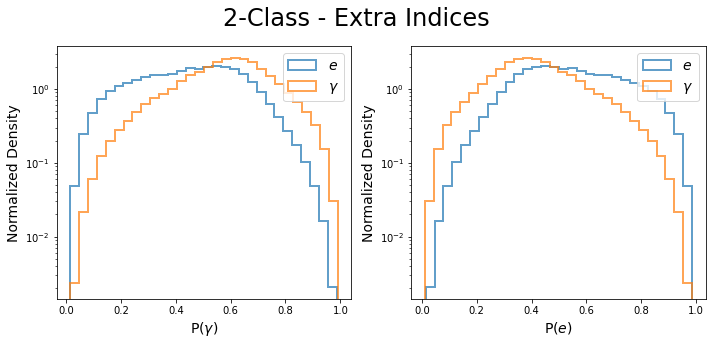

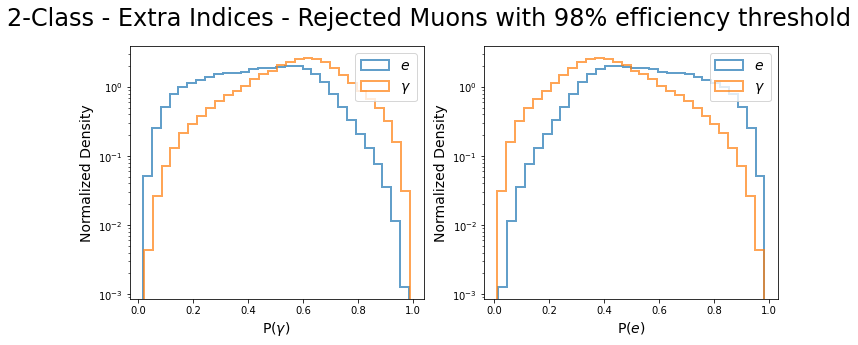

In [39]:
for i in range(len(softmaxes)):
    plot_reduced_classifier_response(softmaxes[i], labels[i],
                                          comparisons_list = [{'independent':['$\gamma$'],
                                                              'dependent':['$e$',"$\gamma$"]},
                                                             {'independent':['$e$'],
                                                              'dependent':['$e$',"$\gamma$"]}
                                                             ],
                                         label_dict=label_dict,
                                         linestyles=linestyle,
                                         title=titles[i],
                                         normalize=True
                                         )